In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [4]:
from keras.applications.mobilenet import MobileNet

In [5]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [6]:
train_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/train"
valid_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/valid"
test_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/test"

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32, shuffle=False)


Found 1084 images belonging to 6 classes.
Found 310 images belonging to 6 classes.
Found 151 images belonging to 6 classes.


In [8]:
imgs, labels = next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


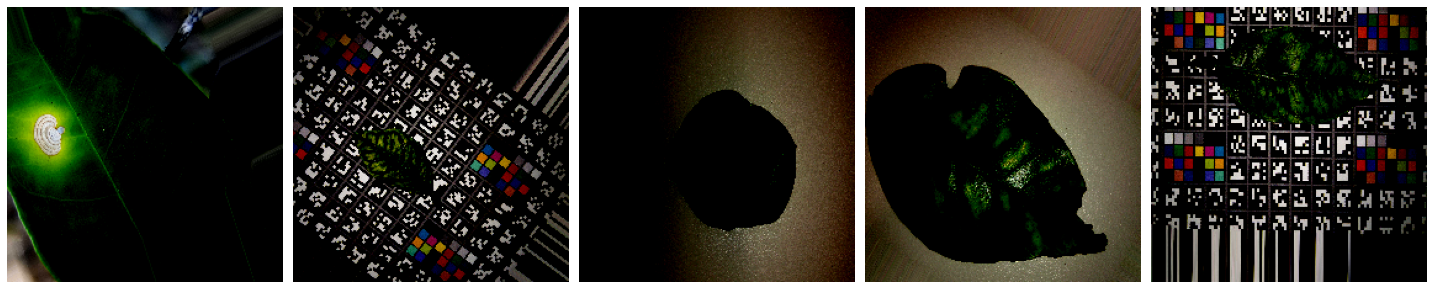

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [10]:
plotImages(imgs)
print(labels)

In [11]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


In [12]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [13]:
for layer in mobilenet_model.layers:
  layer.trainable=False
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [14]:
x = mobilenet_model.layers[-2].output
output = Dense(units=6, activation='softmax')(x)
model = Model(inputs=mobilenet_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [16]:
model_path = '/content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV1_model_v1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [20]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=50,
  callbacks=callbacks_list
)

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 3.4110 - accuracy: 0.2906
Epoch 1: val_accuracy improved from -inf to 0.44839, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV1_model_v1.h5
34/34 [==============================] - 457s 14s/step - loss: 3.4110 - accuracy: 0.2906 - val_loss: 2.0910 - val_accuracy: 0.4484
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.6407 - accuracy: 0.4889
Epoch 2: val_accuracy improved from 0.44839 to 0.55806, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV1_model_v1.h5
34/34 [==============================] - 245s 7s/step - loss: 1.6407 - accuracy: 0.4889 - val_loss: 1.4119 - val_accuracy: 0.5581
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 1.1445 - accuracy: 0.5858
Epoch 3: val_accuracy improved from 0.55806 to 0.64516, saving model to /content/dri

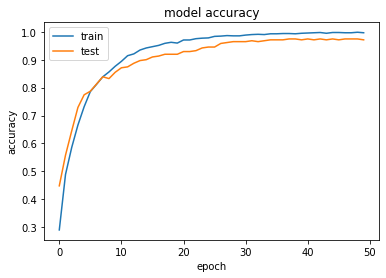

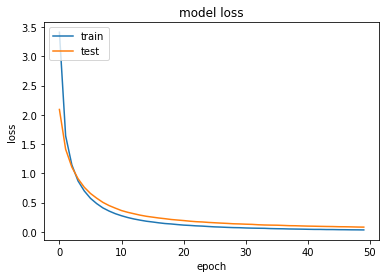

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
rounded_predictions = np.argmax(predictions, axis=-1)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=rounded_predictions)

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
test_batches.class_indices

{'Citrus Greasy Spot': 1,
 'Citrus canker': 0,
 'Citrus variegated chlorosis': 2,
 'Halo Blight': 3,
 'Mosaic': 4,
 'Nutritional Deficiency': 5}

Confusion matrix, without normalization
[[18  0  0  0  0  0]
 [ 0 16  0  0  0  0]
 [ 0  0 55  0  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  1  0 28  1]
 [ 0  0  1  0  0 21]]


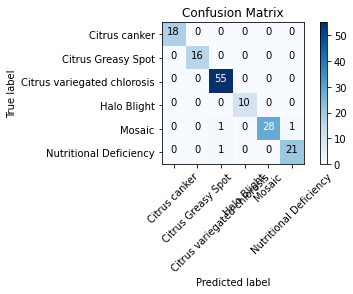

In [33]:
cm_plot_labels=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [34]:
from sklearn.metrics import classification_report

In [35]:
cr = classification_report(y_true=test_batches.classes, y_pred=rounded_predictions, target_names=cm_plot_labels)
print(cr)

                             precision    recall  f1-score   support

              Citrus canker       1.00      1.00      1.00        18
         Citrus Greasy Spot       1.00      1.00      1.00        16
Citrus variegated chlorosis       0.96      1.00      0.98        55
                Halo Blight       1.00      1.00      1.00        10
                     Mosaic       1.00      0.93      0.97        30
     Nutritional Deficiency       0.95      0.95      0.95        22

                   accuracy                           0.98       151
                  macro avg       0.99      0.98      0.98       151
               weighted avg       0.98      0.98      0.98       151

